# Notebook final

## Estructura de archivos y carpetas


* **Code** *Códigos + matlab*
    * **External** *Continene JIDT*
    * **MatlabIsing** *Contiene el código de Matlab para ajuste de modelo ising*
        * **Rasters** *Contiene los rasters para usar en matlab*
        * **Models** *Contiene los modelos generados por matlab*
    * *DataDetails.json - Archivo de conjuntos*
    * *JITDWrapper.py - Wrapper para usar JITD de external*
* **Data** *Carpeta de matrices previamente guardadas*
    * **PreComputed** *Archivos calculados*
        * **MI** *Matrices de información mutua*
        * **H** *Vectores de entropía*
        * *Archivo de distancias de campos receptivos*
        * *Archivo de spikes de 4 retinas bajo 5 estímulos*
* **Documents**
    * *Propuesta - Propuesta de la solución que se propone para lograr lo esperado*
    * *Plan de Implementación - Avances progresivos en el código y propuestas*
    * *Fundamentos - Algunas detalles matemáticos de lo que se hace en el código*
            
**Estructura de nombres de archivos**
    
Se definen los nombres tanto de rasters como de modelos en matlab de la siguiente manera:

`E_C_T_N_R_P_F_S_.mat`

Luego de cada letra sigue un número o numeros que representan lo siguiente

|Letra|Número|
|---|---|
|E|Número de Retina|
|C|Estímulo presentado|
|T|Tiempo de binning|
|N|Neurona a predecir|
|R|Tipo de ranking|
|P|Porcentaje de raster|
|F|Número de neuronas|
|S|Número de sample|

Para los casos de criterio de ranking y sección de raster, el detalle es el siguiente

|Nro|Ranking|Nro|Sección|
|---|---|---|---|
|0|Aleatorio|0|100%|
|1|Aleatorio Incremental|1|70%|
|2|Información Mutua| | 
|3|Distancia de campo receptivo| | 
|4|Correlación| | 

Para la estructura de las predicciones se utiliza el siguiente identificador dentro del archivo `N_.pkl`

`(R,P,F,S,PP)`

Donde las letras `R,P,F,S` corresponden a las definiciones anteriores, y el `PP` Corresponde a lo que fue predicho.

|Nro|Sección|
|---|---|
|0|100%|
|1|70%|
|2|30%| 



## Secciones del código

1. **Preliminares**
    1. Imports
    2. Definición de parametros fijos
    3. Carga/Cómputo de variables almacenadas de uso constante
2. **Selección de neuronas**
    1. Carga de archivo de conjunto de neuronas **(*)**
    2. Computa los conjuntos de neuronas
        1. Aleatorio (5 x 10/20/50/100/120/150)
        2. Aleatorio Incremental (5 x 10/20/50/100/120/150)
        3. En base a información Mutua (1 x 1:10/20/50/100/120/150)
        4. En base a Correlación (1 x 1:10/20/50/100/120/150)
        5. En base a Distancia de Campos receptivos (1 x 1:10/20/50/100/120/150)
3. **Creación de Modelos (\*\*)**
    1. Exportar rasters a formato MATLAB
        1. En formato Completo/Train 70%
    2. Exportar las lineas de código para ejecutar sobre MATLAB
    3. Ejecutar MATLAB **(Externo)**
4. **Cálculo de predicciónes**
    1. Función de predicción de raster en base a modelo
    2. Llamadas a la función de preducción y guardado de resultados
5. **Cálculo de métricas**
    1. Función de cálculo de métricas en base a resultados
    2. Llamadas a función de cálculo de métricas y guardado de resultados
6. **Gráficos**
    1. Visualizar predicciones v/s datos originales
    2. Obtener graficos de las métricas según distintos parámetros
    3. Obtener los espacios de las métricas
7. **Adicionales**
    1. Eliminación de rasters **(\*\*\*)**
    
**(*)** = Sólo si el archivo existe, o de lo contrario se generará uno en el punto 2.

**(\*\*)** = Es necesario hacer esto sólo una vez.

**(\*\*\*)** = Los rasters de matlab sólo se utilizan en el punto 3 y luego se trabaja con los modelos, su generación puede ser muy pesada. En caso de necesitarse nuevamente su generación es rápida y se basa en el archivo de conjuntos del punto 2.

In [15]:
### 1 - Preliminares

#### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import os
import pickle
from matplotlib.ticker import ScalarFormatter
from ipywidgets import interact,IntSlider,interact_manual
from scipy.io import loadmat,savemat
from scipy.ndimage.filters import gaussian_filter1d
from scipy import sparse
from json import loads,dumps
from jpype import *
#from JITDWrapper import *
from sklearn.manifold import MDS
from scipy.spatial import ConvexHull

%matplotlib inline

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
NEWFILES = loadmat("../../mode_paper_data/unique_natural_movie/data.mat")

def dataLoader(file):
    rasterfile = "../Data/Dryad/"+file
    if os.path.isfile(rasterfile+".npz"):
        print("Returning saved sparse matrix",rasterfile.split("/")[-1])
        raster = sparse.load_npz(rasterfile+".npz")
        raster = raster.toarray()
        return raster,raster.shape[0]
    data = loadmat("../../mode_paper_data/"+file+"/data.mat")["data"]["spike_times"]["all_spike_times"]
    Ncount = len(data) #neuron count
    maxdata = max(list(map(max,data)))+200 #max spike time of sample
    raster=np.zeros((Ncount,int(maxdata/200)))  #raster dimensions
    for n in range(Ncount):
        for s in data[n]:
            raster[n][int(s/200)]=1 #binarizing [0,TBIN[ and so on
    print ("Saving sparse matrix")
    sparse.save_npz(rasterfile,sparse.csr_matrix(raster))
    return raster,Ncount


def MutualInformation(file):
    mifile="../Data/Dryad/"+file
    if os.path.isfile(mifile+".npy"):
        print ("Returning PreComputed MIMatrix "+mifile.split("/")[-1])
        return np.load(mifile+".npy")
    raster,Ncount = dataLoader(file)
    calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
    calc = calcClass(2, 2, 0)
    MI = np.zeros((Ncount,Ncount))
    for S in range(Ncount):
        source = JArray(JInt, 1)(raster[S].tolist())
        for D in range(S,Ncount):
            if S==D: continue;
            destination = JArray(JInt, 1)(raster[D].tolist())
            calc.initialise()
            calc.addObservations(source, destination)
            MI[S][D]=calc.computeAverageLocalOfObservations()
        print(S," ",end="")
    np.save(mifile,MI)
    return MI

E="repeated_natural_movie"
RASTER,N = dataLoader(E)
N,T = RASTER.shape
MI= MutualInformation(E)
CC = np.corrcoef(RASTER[:50],RASTER[50:])**2-np.diag(np.ones(N))
MI = MI+MI.T


#### Parámetros Fijos
EXP = 0 # 0 1 2 3
COND = 3 # 0.issa 1.ifsa 2.wn 3.nm 4.ffsa 5. fssa
TBASE = 0.02 #0.001 = 1ms
INTERVAL = 50 # para SpRate
J = 5
NsR = [10,20,50,100,120,N-1]
Ns = [4,5,6,7,8,9,10,20,50,100,120,N-1]
TP = 31 #Neurona a predecir


Returning saved sparse matrix repeated_natural_movie
Returning PreComputed MIMatrix repeated_natural_movie


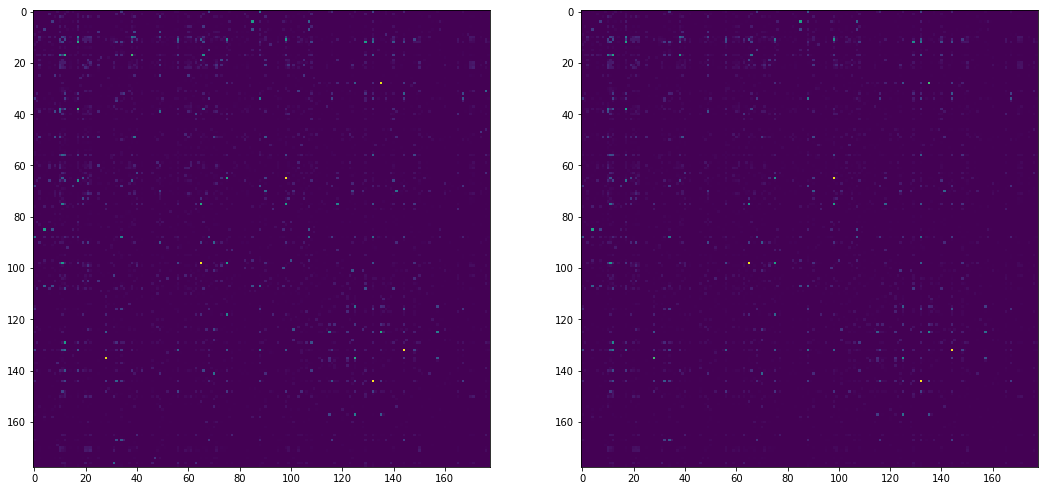

In [27]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.imshow(CC)
plt.subplot(1,2,2)
plt.imshow(MI)

In [249]:
### 2 - Selección de neuronas
#### Carga de archivo
def cargarDataset(TP):
    if "N{0}.json".format(TP) in os.listdir("../Data/Dryad/"):
        with open("../Data/Dryad/N{0}.json".format(TP)) as DD:
            dataset = loads(DD.readline())
        print("Carga de archivo existente para neurona {0}".format(TP))

    #### Creación de Archivo
    else:
        #fixed = int(np.random.choice(range(N)))
        fixed = TP
        free = np.array(list(set(range(N))-{fixed}))
        mienum = sorted([(x[1],x[0]) for x in enumerate(MI[fixed])],reverse=1) #mayor a menor
        miids = list([x[1] for x in mienum])
        miids.remove(fixed)
        cenum = sorted([(x[1],x[0]) for x in enumerate(CC[fixed])],reverse=1)
        cids = list([x[1] for x in cenum])[:-1]
        dataset = {"fixed":fixed,
                   0:dict([(n,[sorted(np.random.choice(free,n,False).tolist()) for j in range(J)]) for n in NsR]),
                   1:{},
                   2:dict([(n,[miids[:n]]) for n in Ns]),
                   3:dict([(n,[cids[:n]]) for n in Ns])}
        newsets=[np.random.choice(list(set(range(N))-{fixed}),N-1,False).tolist() for j in range(J)]
        for n in NsR:
            dataset[1][n]=[]
            for j in range(J):
                dataset[1][n].append(newsets[j][:n])
        with open("../Data/Dryad/N{0}.json".format(TP),"w") as DD:
            DD.write(dumps(dataset))
    return dataset
    
#dataset = {#tipo_selección:{#neuronas:[sample0,sample1,...]}} sampleN = [id0,id1,id2,...]
dataset = cargarDataset(10)

In [250]:
### 3 - Creación de modelos
#### Código para exportar a archivos MATLAB
def saveRasters(neuron):
    dataset=cargarDataset(neuron)
    for rank in [0,1,2,3]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                savemat("../Data/Dryad/Rasters/N{0}R{1}P{2}F{3}S{4}.mat".format(neuron,rank,0,f,s),
                        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:]})
                #savemat("MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s),
                #        {"binnedSpikes":RASTER[[neuron]+dataset[str(rank)][str(f)][s],:int(T*0.7)]})
                #print ("Guardado MatlabIsing/Rasters/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s))

#for localTP in range(115,151): #pend
#    saveRasters(localTP)
#    print(localTP,"OK")
saveRasters(10)

Carga de archivo existente para neurona 10


In [259]:
#### Código para generar las lineas ejecutables en MATLAB
def modelsMatlabLines(neuron):
    filelist = []
    for rank in [0,1,2,3]: #tipo de ranking
        if rank in [0,1]:
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else:
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            #flist,slist = [1,2,3],[0]#,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                filelist.append("N{0}R{1}P{2}F{3}S{4}.mat".format(neuron,rank,0,f,s))
                #filelist.append("E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}".format(EXP,COND,TBASE,neuron,rank,1,f,s))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,0,f,s)))
                #print ("Ajustar('{0}','{1}','{2}');".format('Rasters','Models',
                #                                            "E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,neuron,rank,1,f,s)))
    return filelist

#matlines =  []
#for nn in range(115,151):
#    matlines = matlines+modelsMatlabLines(nn)
#matliness  = modelsMatlabLines(15)
matlines = modelsMatlabLines(4)+modelsMatlabLines(98)+modelsMatlabLines(12)+modelsMatlabLines(132)+modelsMatlabLines(10)

In [267]:
# Del total de nuevos modelos cuantos faltan
foldercont = os.listdir("../Data/Dryad/Models/")
rematlines=[f for f in matlines if f not in foldercont]
print(len(matlines),len(rematlines))
#print(rematlines)

420 0


In [265]:
# Evaluar cuantos rasters tienen sus modelos listos
rastercont = os.listdir("../Data/Dryad/Rasters/")
modelcont = os.listdir("../Data/Dryad/Models/")
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))

2 502 504


In [266]:
### Correr los modelos en matlab
def run_matlab(filename,back=0):
    #print("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/Dryad/Rasters','../../Data/Dryad/Models','{}');exit()" """.format(filename)+["","&"][back])
    #return
    os.system("""matlab -nodisplay -nosplash -nodesktop -r "cd('MatlabIsing');Ajustar('../../Data/Dryad/Rasters','../../Data/Dryad/Models','{}');exit()" """.format(filename)+["","&"][back])

    
sortedlines = sorted(rematlines,key=lambda s: int(s[s.index("F")+1:s.index("S")]))
for sub in range(len(sortedlines))[::5]:
    sl =  sortedlines[sub:sub+5]
    print(sl)
    run_matlab(sl[0],1)
    run_matlab(sl[1],1)
    run_matlab(sl[2],1)
    run_matlab(sl[3],1)
    run_matlab(sl[4],0)


['N12R0P0F10S2.mat', 'N132R1P0F10S1.mat']


IndexError: list index out of range

In [13]:
print (len(set(rastercont)-set(modelcont)),len(modelcont),len(rastercont))
for elem in modelcont:
    if elem in rastercont:
        os.system("rm MatlabIsing/Rasters/"+elem) #deleting raster with model ready
        print("|",end="")

251 15673 3707
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
### 4 - Cómputo de predicciones
#### Función de predicción de raster o spikerate en base al modelo

def PredecirSpRate(TP,r,p,f,s,pp): #neurona,ranking,particion_entreno,fijas,set,particion_eval
    #Carga indices de neuronas y ajusta datos
    dataset=cargarDataset(TP)
    N = f+1
    neuronas = [dataset["fixed"]]+dataset[str(r)][str(f)][s] #Definicion de neuronas a usar desde dataset
    if pp == 0: #full
        data = RASTER[neuronas,:]
    elif pp == 1: #Partial Training
        data = RASTER[neuronas,:int(T*0.7)]
    else: #Partial Testing
        data = RASTER[neuronas,int(T*0.7):]
    print("R{0}P{1}F{2}S{3}PP{4}".format(r,p,f,s,pp),data.T.shape[0]) #DEBUG PRINT
    #Carga el modelo usando los params r/p/f/s 
    ising = loadmat("../Data/Dryad/Models/N{0}R{1}P{2}F{3}S{4}.mat".format(dataset["fixed"],r,p,f,s))
    params = ising["params"] # N , N*(N-1)/2
    #print(params.shape,N,params)
    P = np.zeros((N,N)) #FullMatrix for indexing
    P[np.triu_indices(N, 1)] = params[N:] #UpperTri Matrix
    P = P+np.diag(params[:N]) #<h,sigma>
    
    #Calcula la probabilidad
    obtRate = []
    for t in range(data.T.shape[0]):
        selected = np.array([[1.0]+data.T[t][1:N].tolist(), [0.0]+data.T[t][1:N].tolist()]) # 1/0 + data 1:N
        prob_denom = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(given)
        selected = np.array([[1.0]+data.T[t][1:N].tolist()]) #1 + data 1:N
        prob_num = np.sum(np.exp(np.sum(np.matmul(selected,P)*selected,1))) #Prob P(target,given)
        obtRate.append(prob_num/prob_denom)
    
    #SpikeRate Forward Moving Window
    spRate = np.array([np.sum(data[0][i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    spRatePred = np.array([np.sum(obtRate[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
    
    return obtRate,spRatePred

#### Llamado a la función y almacenamiento de predicción

def cargarPredicciones(TP):
    #Archivo exixstente
    dataset=cargarDataset(TP)
    if "N{0}.pkl".format(dataset["fixed"]) in os.listdir("../Data/Dryad/Predictions/"):
        print("Cargando archivo existente Predictions/N{0}.pkl".format(dataset["fixed"]))
        f = open('../Data/Dryad/Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
        predicciones = pickle.load(f)     
        f.close()
        print("Ok")
    else: #Crea el archivo
        predicciones = {}
        for r in [0,1,2,3]: #tipo de ranking
            if r in [0,1]: #random
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else: #criterio
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0]: #Ratio de entrenamiento SOLAMENTE Full->Full
                        if p==0:
                            predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                        else:
                            predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                            predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
        f = open('../Data/Dryad/Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
        pickle.dump(predicciones, f)          # dump data to f
        f.close()
    return predicciones
#predicciones[(r,p,f,s,0)] 0=full->full

for n in [4,10,12,98,132]:
    OUT = cargarPredicciones(n)

Carga de archivo existente para neurona 4
Carga de archivo existente para neurona 4
R0P0F10S0PP0 443620
Carga de archivo existente para neurona 4
R0P0F10S1PP0 443620
Carga de archivo existente para neurona 4
R0P0F10S2PP0 443620
Carga de archivo existente para neurona 4
R0P0F10S3PP0 443620
Carga de archivo existente para neurona 4
R0P0F10S4PP0 443620
Carga de archivo existente para neurona 4
R0P0F20S0PP0 443620
Carga de archivo existente para neurona 4
R0P0F20S1PP0 443620
Carga de archivo existente para neurona 4
R0P0F20S2PP0 443620
Carga de archivo existente para neurona 4
R0P0F20S3PP0 443620
Carga de archivo existente para neurona 4
R0P0F20S4PP0 443620
Carga de archivo existente para neurona 4
R0P0F50S0PP0 443620
Carga de archivo existente para neurona 4
R0P0F50S1PP0 443620
Carga de archivo existente para neurona 4
R0P0F50S2PP0 443620
Carga de archivo existente para neurona 4
R0P0F50S3PP0 443620
Carga de archivo existente para neurona 4
R0P0F50S4PP0 443620
Carga de archivo existente p

In [271]:
def reducPredicciones(TP):
    f = open('../Data/Dryad/Predictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    minipredicciones={}
    for r in [0,1,2,3]: #tipo de ranking
        if r in [0,1]: #random
            flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
        else: #criterio
            flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                minipredicciones[(r,0,f,s,0)] = predicciones[(r,0,f,s,0)][1][:3000]
    f = open('../Data/Dryad/mPredictions/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(minipredicciones, f)          # dump data to f
    f.close()
#for p in range(10,85):
for n in [4,10,12,98,132]:
    reducPredicciones(n)


In [ ]:
#FIX PREDICCIONES
#correccion de r=2, f=completo s=0 p,pp = 1,1 y 1,2
def FixPredicc(TP):
    dataset=cargarDataset(TP)
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'rb')   # 'rb' for reading binary file
    predicciones = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #Ratio de entrenamiento
                    if p==0:
                        predicciones[(r,p,f,s,0)] = PredecirSpRate(TP,r,p,f,s,0) #Full a Full
                    else:
                        predicciones[(r,p,f,s,1)] = PredecirSpRate(TP,r,p,f,s,1) #Partial a Partial
                        predicciones[(r,p,f,s,2)] = PredecirSpRate(TP,r,p,f,s,2) #Partial a Testing
    f = open('Predictions/N{0}.pkl'.format(dataset["fixed"]), 'wb')
    pickle.dump(predicciones, f)          # dump data to f
    f.close()


In [ ]:
### 5 - Cálculo de métricas
#### Función para calcular las métricas en base a una predicción
def ObtenerMetricas(TP,r,p,f,s,pp):
    #Original Data
    if pp == 0: #full
        data = RASTER[dataset["fixed"],:]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,data.T.shape[0]-50)])/(1/TBASE)
        
    elif pp == 1: #Partial Training
        data = RASTER[dataset["fixed"],:int(T*0.7)]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(data.T.shape[0]*0.7)-50)])/(1/TBASE)
    else: #Partial Testing
        data = RASTER[dataset["fixed"],int(T*0.7):]
        spRate = np.array([np.sum(data[i:i+50]) for i in range(0,int(data.T.shape[0]*0.3)-50+1)])/(1/TBASE)
        
    # Predicted Data
    preData,preSp = predicciones[(r,p,f,s,pp)]
    print (p,pp,len(data),len(spRate),len(preData),len(preSp))
    #Raw Distance|R and SpRate Distance|R
    dataDist = np.round(np.linalg.norm(data-preData),3)
    dataR = np.round(np.corrcoef(data,preData)[0,1],3)
    spDist = np.round(np.linalg.norm(spRate-preSp),3)
    spR = np.round(np.corrcoef(spRate,preSp)[0,1],3)
    return [(dataDist,dataR),(spDist,spR)]
    
#### Llamados a función de cálculo de metricas y almacenamiento de los resultados
def cargarMedidas(TP):
    if "N{0}.pkl".format(TP) in os.listdir("../Data/Dryad/Measures/"):
        #print("Cargando archivo existente Measures/N{0}.pkl".format(TP))
        f = open('../Data/Dryad/Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
        medidas = pickle.load(f)     
        f.close()
        #print("Ok")
    else:
        medidas = {}
        for r in [0,1,2,3]: #tipo de ranking
            if r in [0,1]:
                flist,slist = [10,20,50,100,120,150],[0,1,2,3,4]
            else:
                flist,slist = [4,5,6,7,8,9,10,20,50,100,120,150],[0]
            for f in flist: #neuronas fijadas
                for s in slist: #samples
                    for p in [0]: #particiones
                        if p==0:
                            medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                        else:
                            medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                            medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
        f = open('../Data/Dryad/Measures/N{0}.pkl'.format(TP), 'wb')
        pickle.dump(medidas, f)          # dump data to f
        f.close()
        print("OK")
    return medidas
#medidas = {(r,0,f,s,pp):[(dataDist,dataR),(spDist,spR)]}
for n in [4,10,12,98,132]:
    predicciones = cargarPredicciones(n)
    m = cargarMedidas(n)

In [ ]:
def FixMedidas(TP):
    f = open('Measures/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    medidas = pickle.load(f)     
    f.close()
    for r in [2]: #tipo de ranking
        flist,slist = [1,2,3,4,5,6,7,8,9,10,20,50,100,120,150],[0]
        for f in flist: #neuronas fijadas
            for s in slist: #samples
                for p in [0,1]: #particiones
                    if p==0:
                        medidas[(r,p,f,s,0)] = ObtenerMetricas(TP,r,p,f,s,0) #de full a full
                    else:
                        medidas[(r,p,f,s,1)] = ObtenerMetricas(TP,r,p,f,s,1) #de parcial a training
                        medidas[(r,p,f,s,2)] = ObtenerMetricas(TP,r,p,f,s,2) #de parcial a testing
    f = open('Measures/N{0}.pkl'.format(TP), 'wb')
    pickle.dump(medidas, f)          # dump data to f
    f.close()
    print("OK")
for fix in [147,127,120,119,49,31,20,2]:
    predicciones=cargarPredicciones(fix)
    FixMedidas(fix)

# WorkFlow

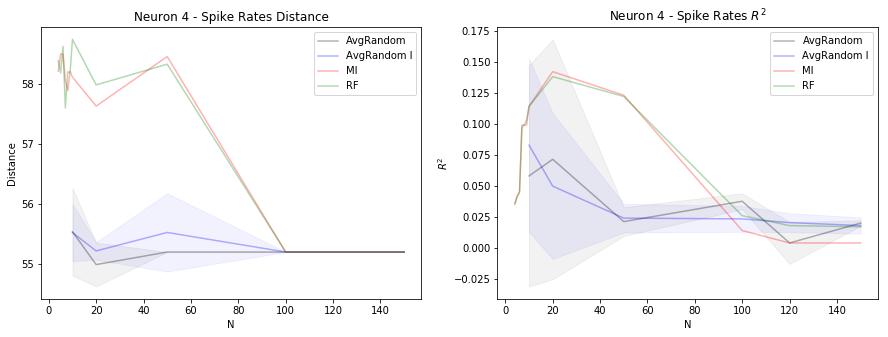

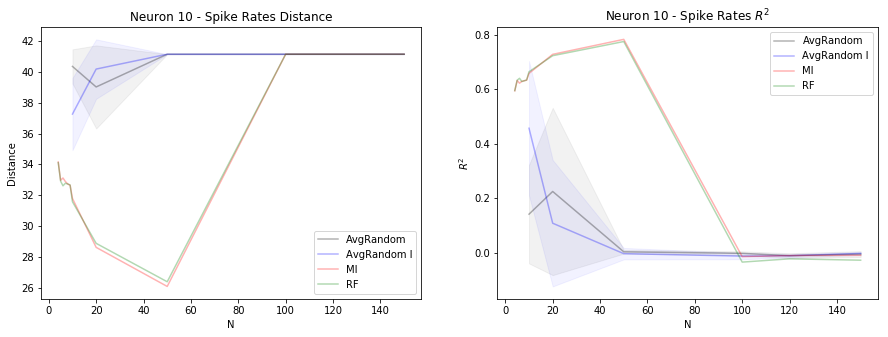

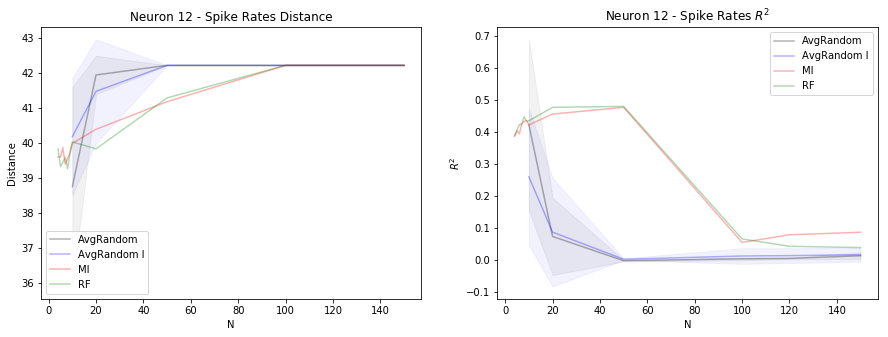

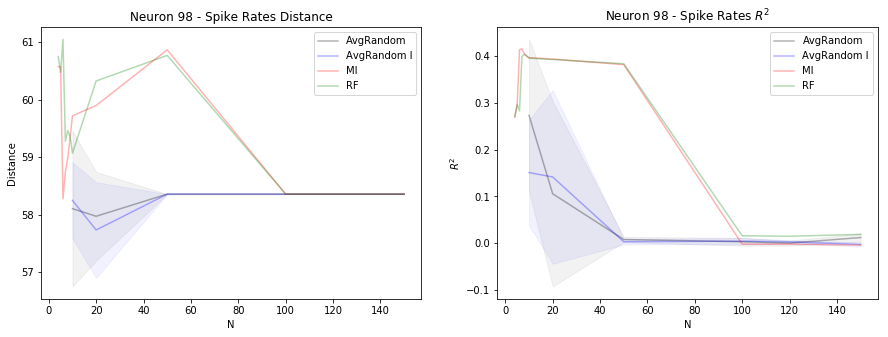

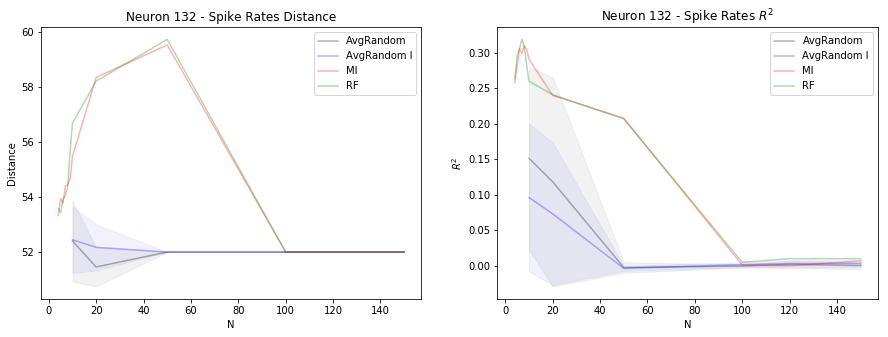

In [270]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def measurePlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    p,pp = [(0,0),(1,1),(1,2)][pconv]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    A = 6
    B = 15
    for t in [1]:
        for m in [0,1]:
            #plt.figure(figsize=(16,15))
            #plt.subplot(4,1,m*2+t+1)
            plt.subplot(1,2,m+1)
            plt.xlabel("N");plt.ylabel(med[m])
            rand = [np.array([medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            irand = [np.array([medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]]) for s in range(5)]
            stdrand = np.std(rand,axis=0)
            stdirand = np.std(irand,axis=0)
            plt.plot(NsR[:A],sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
            plt.fill_between(NsR[:A], sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
            plt.plot(NsR[:A],sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
            plt.fill_between(NsR[:A], sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
            #for s in range(4):
            #    plt.plot(NsR[:A],[medidas[(0,p,f,s,pp)][t][m] for f in NsR[:A]],"k.")
            #    plt.plot(NsR[:A],[medidas[(1,p,f,s,pp)][t][m] for f in NsR[:A]],"b-",alpha=0.3)
            plt.plot(Ns[:B],[medidas[(2,p,f,0,pp)][t][m] for f in Ns[:B]],"r-",alpha=0.3,label="MI")
            plt.plot(Ns[:B],[medidas[(3,p,f,0,pp)][t][m] for f in Ns[:B]],"g-",alpha=0.3,label="RF")
            #plt.plot(Ns[:B],[medidas[(4,p,f,0,pp)][t][m] for f in Ns[:B]],"k-",alpha=0.3,label="Correl")
            plt.legend()
            plt.title("Neuron {0} - {2} {1}".format(TP,med[m],tip[t]))
    plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")
#plt.plot(range(T-50)[:1000],np.array([np.sum(RASTER[dataset["fixed"]][i:i+50]) for i in range(0,T-50)])[:1000]/(1/TBASE))
#plt.plot(range(T-50)[:1000],predicciones[(0,0,50,4,0)][1][:1000])
#measurePlotter(0,"FullFull")
#measurePlotter(1,"PartialTrain")
#measurePlotter(2,"PartialTest")
#for tp in [2,10,20,30]:
#    dataset = cargarDataset(tp)    
    #measurePlotter(tp,2,"PT")
for n in [4,10,12,98,132]:
    measurePlotter(n,0,"FF")

In [ ]:
# TP = 147
#medidas = {(r,0,f,s,pp)
# (p,pp) -> (0,0), (1,1), (1,2)
def memoriaPlotter(TP,pconv,plotfile):
    #predicciones = cargarPredicciones(TP)
    #print(TP)
    medidas = cargarMedidas(TP)
    plt.figure(figsize=(15,5))
    #p,pp = [(0,0),(1,1),(1,2)][pconv]
    pselect = [(0,0),(1,1),(1,2)]
    med = ["Distance","$R^2$"]
    tip = ["Spikes","Spike Rates"]
    nom = ["Full-Full","Train-Train","Train-Test"]
    t,m= 1,1
    for pconv in [0,1,2]:
        p,pp = pselect[pconv]
        plt.subplot(1,3,pconv+1)
        plt.xlabel("N");plt.ylabel(med[m])
        rand = [np.array([medidas[(0,p,f,s,pp)][t][m] for f in NsR]) for s in range(5)]
        irand = [np.array([medidas[(1,p,f,s,pp)][t][m] for f in NsR]) for s in range(5)]
        stdrand = np.std(rand,axis=0)
        stdirand = np.std(irand,axis=0)
        plt.plot(NsR,sum(rand)/5,"k-",alpha=0.3,label="AvgRandom")
        plt.fill_between(NsR, sum(rand)/5 - stdrand, sum(rand)/5 + stdrand, alpha=0.05,color="k")
        plt.plot(NsR,sum(irand)/5,"b-",alpha=0.3,label="AvgRandom I")
        plt.fill_between(NsR, sum(irand)/5 - stdirand, sum(irand)/5 + stdirand, alpha=0.05,color="b")
        plt.plot(Ns,[medidas[(2,p,f,0,pp)][t][m] for f in Ns],"r-",alpha=0.3,label="MI")
        plt.plot(Ns,[medidas[(3,p,f,0,pp)][t][m] for f in Ns],"g-",alpha=0.3,label="RF")
        plt.plot(Ns,[medidas[(4,p,f,0,pp)][t][m] for f in Ns],"k-",alpha=0.3,label="Correl")
        plt.legend()
        plt.title("Neuron {0} - {2} {1} {3}".format(TP,med[m],tip[t],nom[pconv]))
        plt.savefig("plot{0}".format(dataset["fixed"])+plotfile+".svg")
#plt.plot(range(T-50)[:1000],np.array([np.sum(RASTER[dataset["fixed"]][i:i+50]) for i in range(0,T-50)])[:1000]/(1/TBASE))
#plt.plot(range(T-50)[:1000],predicciones[(0,0,50,4,0)][1][:1000])
#measurePlotter(0,"FullFull")
#measurePlotter(1,"PartialTrain")
#measurePlotter(2,"PartialTest")
for tp in [2,31,49,72,119,120,127,147]:
    dataset = cargarDataset(tp)
    memoriaPlotter(tp,0,"FF")
    

E0C3T0.02N30R3P0F50S0


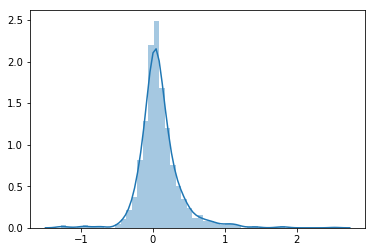

In [350]:
modname=matlines[80]
N=51
print(modname)
ising = loadmat("MatlabIsing/Models/{}.mat".format(modname))
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
H = np.diag(params[:,0][:N]) #<h,sigma>
sns.distplot(params[N:])

In [241]:
# Measure Comparation -> Avg(Random), Avg(RandomInc), MI, C, RF 
# SpRate - R2 is absolute -> more is better
# default p,pp = 0,0
# default t,m = 1,1
def rankingMedidas(TP):
    p,pp =0,0
    medidas = cargarMedidas(TP)
    ranks = ["AvgRand","AvgIncRand","MI","RF","Corr"]
    norms = [np.linalg.norm(sum([np.array([medidas[(r,p,f,s,pp)][1][1] for f in NsR]) for s in range(ss)])/ss) for r,ss in [(0,5),(1,5),(2,1),(3,1),(4,1)]]
    norms = list(zip(ranks,norms))
    return list(zip(*sorted(norms,key=lambda x:x[1],reverse=True)))[0]

stats([10,2,20,31,49,72,119,120,127,147])
for n in [10,2,20,31,49,72,119,120,127,147]:
    print(n,rankingMedidas(n))

RF:143 - Cor:143 - MI:10 - SP:86
RF:30 - Cor:36 - MI:70 - SP:10
RF:48 - Cor:55 - MI:19 - SP:24
RF:19 - Cor:27 - MI:15 - SP:12
RF:90 - Cor:99 - MI:142 - SP:84
RF:4 - Cor:7 - MI:3 - SP:58
RF:15 - Cor:6 - MI:87 - SP:113
RF:100 - Cor:92 - MI:103 - SP:83
RF:131 - Cor:122 - MI:136 - SP:149
RF:22 - Cor:22 - MI:91 - SP:21
10 ('AvgIncRand', 'AvgRand', 'MI', 'Corr', 'RF')
2 ('RF', 'MI', 'Corr', 'AvgRand', 'AvgIncRand')
20 ('MI', 'Corr', 'RF', 'AvgIncRand', 'AvgRand')
31 ('Corr', 'MI', 'RF', 'AvgIncRand', 'AvgRand')
49 ('MI', 'Corr', 'RF', 'AvgRand', 'AvgIncRand')
72 ('MI', 'Corr', 'RF', 'AvgIncRand', 'AvgRand')
119 ('RF', 'MI', 'Corr', 'AvgRand', 'AvgIncRand')
120 ('MI', 'Corr', 'RF', 'AvgRand', 'AvgIncRand')
127 ('Corr', 'MI', 'RF', 'AvgRand', 'AvgIncRand')
147 ('RF', 'MI', 'Corr', 'AvgRand', 'AvgIncRand')


In [113]:
np.std([np.random.randint(1,10,5) for x in range(8)],axis=0)

array([2.34520788, 2.43669859, 2.28787565, 2.04633819, 2.23606798])

In [ ]:
def plotpredictedsprate(TP,r,f,s,window,steps,name="SpFigure"):
    data,SP = predicciones[(r,0,f,s,0)]
    #rank = {0:"Aleatorio",1:"Aleatorio Incremental",2:"por Información Mutua",4:"por Correlación",3:"por Campo Receptivo"}
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    sp = np.array([np.sum(RASTER[TP][i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #psp = np.array([np.sum(data[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    #totalact = np.sum(RASTER,axis=0)/RASTER.shape[0]
    #tsp = np.array([np.sum(totalact[i:i+window]) for i in range(0,T-window)])/(1/TBASE)
    ccoef = round(np.corrcoef(sp[:steps],SP[:steps])[0,1],2)
    ccoeft = round(np.corrcoef(sp[:],SP[:])[0,1],2)
    plt.figure(figsize=(25,5))
    #plt.title("Neurona {0} predicha en base a {1} neuronas del sample {2} {3} w_size={4} R2={5} // {6}".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.title("Neuron {0} predicted by {1} neurons from {3} sample {2} [w_size={4} R2={5} // tR2={6}]".format(TP,f,s,rank[r],window,ccoef,ccoeft))
    plt.plot(range(steps),gaussian_filter1d(sp[:steps],sigma=3),label="Original")
    #plt.plot(range(steps),gaussian_filter1d(psp[:steps],sigma=3),label="Predicted")
    plt.plot(range(steps),gaussian_filter1d(SP[:steps],sigma=3),label="Predicted")
    #plt.plot(range(steps),gaussian_filter1d(tsp[:steps],sigma=3),"--",label="RasterAverage",alpha=0.3)
    plt.ylabel("Spike Rate")
    plt.xlabel("Time Bin")
    plt.legend()
    plt.show()
    #m = max(max(sp[:steps]),max(psp[:steps]))
    #dists = np.array([np.sqrt(abs(sp[n]-psp[n])/np.sqrt(2)) for n in range(steps)])
    #dists/=max(dists)
    #plt.scatter(a,b,c=[[1-d,d,1] for d in dists],marker=".")
    #plt.scatter(sp[:steps],psp[:steps],marker=".",alpha=0.1)
    #plt.show()
    #plt.savefig(name+".png")
    
    #plt.figure(figsize=(10,10))
    #plt.scatter(sp[:steps],psp[:steps],alpha=0.03)


obj = 162
predicciones = cargarPredicciones(obj)
plotpredictedsprate(obj,0,50,0,50,3000)
plotpredictedsprate(obj,0,120,0,50,3000)
plotpredictedsprate(obj,2,10,0,50,3000)
plotpredictedsprate(obj,2,100,0,50,3000)


In [32]:
#SpRate plot para mPredictions
def Plot(TP,r,f,s,r2,f2,s2):
    F = open('../Data/Dryad/mPredictions/N{0}.pkl'.format(TP), 'rb')   # 'rb' for reading binary file
    mpredicciones = pickle.load(F)    
    F.close()
    SP = mpredicciones[(r,0,f,s,0)]
    SP2 = mpredicciones[(r2,0,f2,s2,0)]
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",3:"Correlation Ranked"}
    rrank = {0:"Rand",1:"Inc. Rand",2:"MI Rank",3:"Corr Rank"}
    sp = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(25,5))
    plt.title("Neuron {0} predicted by (1)[{1} neurons from {2} sample {3}] and (2)[{4} neurons from {5} sample {6}]".format(TP,f,rank[r],s,f2,rank[r2],s2))
    plt.plot(range(3000),gaussian_filter1d(sp[:3000],sigma=3),label="Original")
    plt.plot(range(3000),gaussian_filter1d(SP,sigma=3),label=rrank[r]+str(f),alpha=0.6)
    plt.plot(range(3000),gaussian_filter1d(SP2,sigma=3),label=rrank[r2]+str(f2),alpha=0.6)
    plt.ylabel("Spike Rate")
    plt.xlabel("Time Bin")
    plt.legend()
    plt.show()

#for n in [4,10,12,98,132]:
interact_manual(Plot,TP=[4,10,12,98,132,162],
               r=(0,3,1),f=[10,20,50,100,120,150],s=0,
               r2=(0,3,1),f2=[10,20,50,100,120,150],s2=0)
#interact_manual(Plot,TP=(0,84,1),
#               r=(0,4,1),f=[10,20,50,100,120,150],s=0)
#N= 21,29

interactive(children=(Dropdown(description='TP', options=(4, 10, 12, 98, 132, 162), value=4), IntSlider(value=…

<function __main__.Plot(TP, r, f, s, r2, f2, s2)>

In [113]:
# Overall f=[5,10,20] R^2
nlist = list(range(20,30))
listaMedidas = [cargarMedidas(n) for n in nlist]
for r in [0,1,2,3,4]:
    print("Criterio",r,*["%6s"%nn for nn in nlist])
    for f in [10,20,50,100,120,150]: #sample 0 full-full
        print("Fijas:","%3s"%f,end=" ")
        for n in range(len(nlist)):
            print("%6s" % listaMedidas[n][(r,0,f,0,0)][1][1],end=" ")
        print()

Criterio 0     20     21     22     23     24     25     26     27     28     29
Fijas:  10  0.468  0.123  0.299  0.037    0.4  0.377  0.568  0.247   0.64  0.437 
Fijas:  20  0.613  0.613  0.337  0.176  0.432  0.581  0.553  0.325  0.293   0.59 
Fijas:  50  0.622  0.593  0.497  0.366  0.523  0.773  0.664  0.484  0.662  0.688 
Fijas: 100  0.668  0.817  0.497  0.448  0.597  0.805  0.687  0.632  0.558  0.777 
Fijas: 120  0.812   0.82  0.543  0.423  0.608  0.841  0.666  0.664   0.52   0.82 
Fijas: 150  0.847  0.859  0.595  0.489  0.619  0.877  0.688  0.709  0.671  0.834 
Criterio 1     20     21     22     23     24     25     26     27     28     29
Fijas:  10   0.39  0.281   0.26  0.017  0.417  0.413  0.409  0.033  0.355  0.534 
Fijas:  20  0.734   0.35  0.396  0.037  0.539  0.568   0.51  0.249  0.413  0.612 
Fijas:  50  0.794  0.493   0.41   0.32   0.57  0.743  0.604  0.519  0.512  0.789 
Fijas: 100  0.837  0.835  0.551  0.436  0.581  0.826  0.654  0.682  0.664  0.813 
Fijas: 120   0.84 

In [22]:
todasMedidas = [cargarMedidas(n) for n in range(151)]

In [17]:
def plotMedida(r,f,r2,f2,sort):
    rank = {0:"Random",1:"Incremental Random",2:"Mutual Information Ranked",4:"Correlation Ranked",3:"Receptive Field Ranked"}
    plt.figure(figsize=(15,5))
    yData=[todasMedidas[n][(r,0,f,0,0)][1][1] for n in range(151)]
    yData2=[todasMedidas[n][(r2,0,f2,0,0)][1][1] for n in range(151)]
    if sort:
        yData=sorted(yData)[::-1]
        yData2=sorted(yData2)[::-1]
    plt.title(rank[r]+" Fijas: {0}".format(f))
    plt.scatter(range(151),yData,label="1")
    plt.plot(range(151),yData,alpha=0.5)
    plt.scatter(range(151),yData2,label="2")
    plt.plot(range(151),yData2,alpha=0.5)
    plt.ylabel("$R^2$")
    plt.xlabel("Neuronas")
    plt.grid()
    plt.show()
interact_manual(plotMedida,r=(0,4,1),f=[10,20,50,100,120,150],r2=(0,4,1),f2=[10,20,50,100,120,150],sort=False)
# Poder comparar perfiles de ranking (idem comparación de predicciones arriba) , agregar leyenda
#---
# Fijar R2 y ver # de neuronas

interactive(children=(IntSlider(value=2, description='r', max=4), Dropdown(description='f', options=(10, 20, 5…

<function __main__.plotMedida(r, f, r2, f2, sort)>

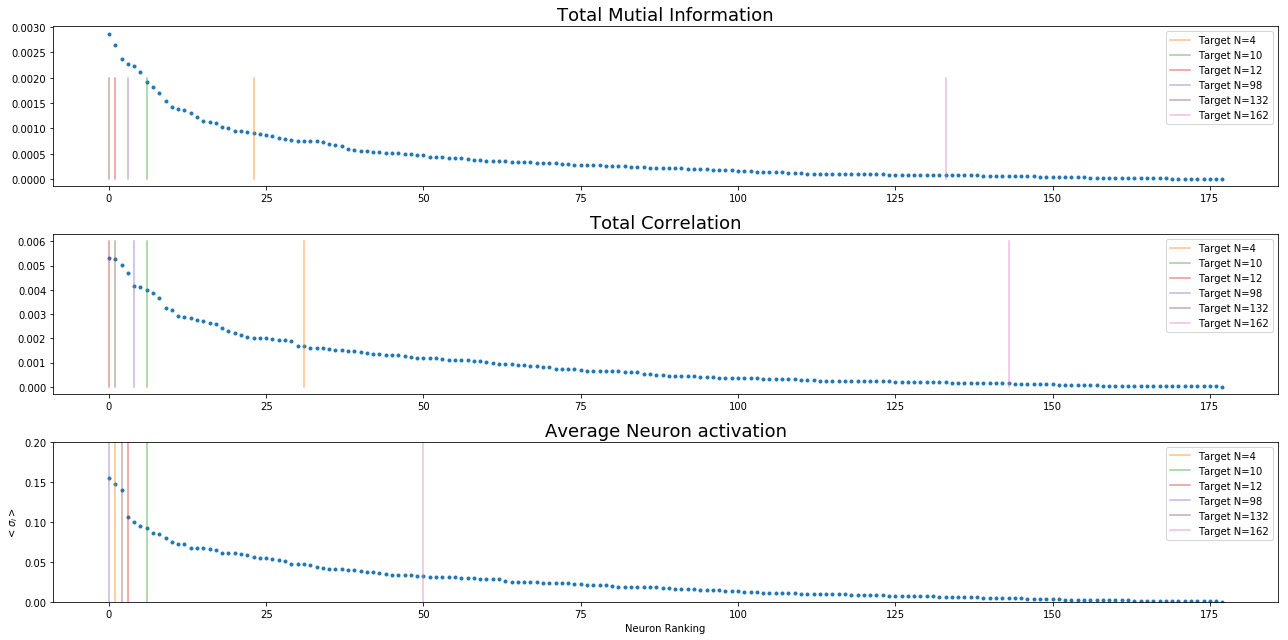

In [31]:
### 6 - Generación de visualizaciones
#### Función de visualización de raster/spRate v/s su predicción correspondiente
def spRateVis(r,f,s,window,size): #ranking fixed sample
    predicted = predicciones[(r,0,f,s,0)][1] #datos
    #preSpRate = np.array([np.sum(predicted[i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    spRate = np.array([np.sum(RASTER[TP][i:i+50]) for i in range(0,T-50)])/(1/TBASE)
    plt.figure(figsize=(25,5))
    plt.plot(range(3000),predicted[:3000])
    plt.plot(range(3000),spRate[:3000])
    plt.title("cosa")
    plt.xlabel("t")
    plt.ylabel("SpikeRate")
    return 0
#### Función para visualizar las métricas de rendimiento de las predicciones

#### Función para visualizar los espacios de métricas utilizadas

    
def caracterizacion1D(neurons):
    fig = plt.figure(figsize=(18,9))
    plt.subplot(3,1,1)
    plt.title("Total Mutial Information",fontsize=18)
    mirank = sorted(np.sum(MI,axis=1)/MI.shape[1],reverse=1)
    plt.plot(range(MI.shape[0]),mirank,".")
    for neuron in neurons:
        plt.plot([mirank.index(np.sum(MI,axis=1)[neuron]/MI.shape[1])]*2,[0.0,0.002],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.subplot(3,1,2)
    plt.title("Total Correlation",fontsize=18)
    ccrank = sorted(np.sum(CC,axis=1)/CC.shape[1],reverse=1)
    plt.plot(range(CC.shape[0]),ccrank,".")
    for neuron in neurons:
        plt.plot([ccrank.index(np.sum(CC,axis=1)[neuron]/CC.shape[1])]*2,[0.0,0.006],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    #plt.subplot(4,1,3)
    #plt.title("Total Receptive Field Distance",fontsize=18)
    #rfrank = sorted(np.sum(D,axis=1)/D.shape[1])
    #plt.plot(range(D.shape[0]),rfrank,".")
    #for neuron in neurons:
    #    plt.plot([rfrank.index(np.sum(D,axis=1)[neuron]/D.shape[1])]*2,[0.0,6],alpha=0.5,label="Target N={0}".format(neuron))
    #plt.legend()
    plt.subplot(3,1,3)
    plt.title("Average Neuron activation",fontsize=18)
    plt.ylabel("$<\sigma_i>$")
    plt.xlabel("Neuron Ranking")
    plt.ylim(0.0,0.2)
    sprank = sorted(np.sum(RASTER,axis=1)/RASTER.shape[1],reverse=1)
    plt.plot(range(RASTER.shape[0]),sprank,".")
    for neuron in neurons:
        plt.plot([sprank.index(np.sum(RASTER,axis=1)[neuron]/RASTER.shape[1])]*2,[0.0,1.0],alpha=0.5,label="Target N={0}".format(neuron))
    plt.legend()
    plt.tight_layout()
    return fig
    
def stats(neuron): #Avg SpRate, Sum(MI),Sum(D),Sum(C) & Ranks
    #Dindex,Dsums = list(zip(*sorted(enumerate(np.sum(D,axis=1)),key=lambda x:x[1])))
    Cindex,Csums = list(zip(*sorted(enumerate(np.sum(CC,axis=1)),reverse=True,key=lambda x:x[1])))
    MIindex,MIsums = list(zip(*sorted(enumerate(np.sum(MI,axis=1)),reverse=True,key=lambda x:x[1])))
    SPindex,SPsums = list(zip(*sorted(enumerate(np.sum(RASTER,axis=1)),reverse=True,key=lambda x:x[1])))
    #for neuron in neurons:
    #    print("RF:{} - Cor:{} - MI:{} - SP:{}".format(MIindex.index(neuron),Cindex.index(neuron),Dindex.index(neuron),SPindex.index(neuron)))
    #return [MIindex.index(neuron),Cindex.index(neuron),0,SPindex.index(neuron)]
    #print("RF Distance:\n{0}\t#{1}\nSumMI:\n{2}\t#{3}\nSumCC\n{4}\t{5}".format(ds,Dsums.index(ds),ms,MIsums.index(ms),cs,Csums.index(cs)))


        

#interact(caracterizacion,neuron=IntSlider(min=0,max=N, step=1,value=dataset["fixed"]))

neuronset = [4,10,12,98,132,162]
caracterizacion1D(neuronset)
stats(neuronset)

In [29]:
### 7 - Misc
#### Función para eliminar todos los rasters generados para MATLAB
N,T

(178, 443620)

In [182]:
for T in []:
    ds = cargarDataset(T)
    enu = sorted(enumerate(MI[T]),key = lambda x:x[1],reverse=1)
    unzipe = list(list(zip(*list(enu)))[0])
    unzipe.remove(T)
    dedat = ds["2"]["150"][0]
    print(unzipe)
    print(dedat)
    plt.scatter(unzipe,dedat,marker=".")
ising = loadmat("MatlabIsing/Models/E{0}C{1}T{2}N{3}R{4}P{5}F{6}S{7}.mat".format(EXP,COND,TBASE,147,2,1,9,0))
N=10
params = ising["params"] # N , N*(N-1)/2
#print(params[:,0],len(params[:,0]),N)
P = np.zeros((N,N)) #FullMatrix for indexing
P[np.triu_indices(N, 1)] = params[:,0][N:] #UpperTri Matrix
P = P+np.diag(params[:,0][:N]) #<h,sigma>

# No considerar de acá hacia abajo

In [26]:
np.sum(RASTER,axis=0)

array([0., 0., 0., ..., 7., 7., 5.])

In [110]:
max(NEWFILES["data"]["spike_times"]["all_spike_times"][4])/200

246250.595

Returning saved sparse matrix repeated_natural_movie
Returning PreComputed MIMatrix repeated_natural_movie


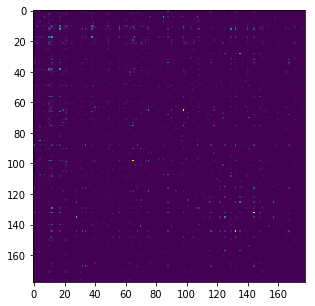

In [145]:
plt.figure(figsize=(15,5))
plt.imshow(mat[:,:15000],aspect="auto")
plt.imshow(MI)

In [22]:
sorted(enumerate(np.sum(RASTER,axis=1)/RASTER.shape[1]),key=lambda x:x[-1],reverse=True)[:10]

[(98, 0.1542130652360128),
 (4, 0.14733104909607322),
 (132, 0.13980884540823227),
 (12, 0.10638158784545332),
 (144, 0.09918173211306974),
 (34, 0.09511068031197872),
 (10, 0.09206528109643389),
 (85, 0.08541769983319057),
 (76, 0.08435823452504396),
 (17, 0.08028492854244623)]